In [1]:
# import the required python modules

import ceviche
import matplotlib.pylab as plt
import numpy as np
from numpy import pi, real, conj

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [2]:
from ceviche_utilities import *

In [3]:
# constants

EPSILON_0 = 8.85418782e-12              # vacuum permittivity
MU_0 = 1.25663706e-6                    # vacuum permeability
C_0 = 1 / np.sqrt(EPSILON_0 * MU_0)     # speed of light in vacuum
Q_e = 1.602176634e-19                   # funamental charge

In [4]:
def pxl(x):
    '''converts meters to pixels (dl)'''
    return int(x/dl)

In [5]:
# parameters

################################################################################
# geometry

a = 200e-9          # grating period (in m)
F = 0.5             # grating fill factor
h = 175e-9          # grating tooth height
d = 20e-9           # impact parameter
base = 100e-9       # grating base height
xR_PML = 700e-9     # distance from the right PML to the bottom of the grating
xL_PML = 200e-9     # distance from the left PML to the electron path
detector = 100e-9   # separation between the detectors and the PMLs

################################################################################
# FD simulation parameters

dl = 4e-9            # element size (in m)
Npml = 20            # Size of the PML boundaries in pixels 

# Simulation domain size (in number of pixels)
Nx = int((xR_PML + xL_PML + base + h + d) / dl) + 2*Npml + 1
Ny = int(a / dl) + 1
   
################################################################################
# material

n = 3.91             # refractive index
val_epsr = n**2      # relative permittivity

################################################################################
# electron beam

beta = 0.32838       # electron relative velocity
sigma_x = 3e-9       # electron beam sigma_x  

################################################################################
# radiation

m = 1                   # spectral order
theta = (90)*pi/180     # radiation angle

# frequency from iSPR equation (in Hz):
omega = 2*pi*m*beta*C_0 / (Ny*dl*(1-beta*n*np.cos(theta)))
# omega = 600e12 * 2* pi  

################################################################################

In [6]:
print(f'Nx, Ny:\t\t{(Nx, Ny)}')
print(f'omega:\t\t{(omega):.2e}')

Nx, Ny:		(339, 50)
omega:		3.77e+15


In [7]:
# Initialize relative permittivity of the domain
epsr = np.ones((Nx, Ny))

#################################################
# grating for Smith-Purcell

x1 = Npml + int((xL_PML + d) / dl)
x2 = Npml + int((xL_PML + d + h) / dl)
y1 = int(Ny/2*(1-F))
y2 = int(Ny/2*(1-F) + F*Ny)
epsr[x2:Nx, 0:y1]  = val_epsr
epsr[x1:Nx, y1:y2] = val_epsr
epsr[x2:Nx, y2:Ny] = val_epsr
#################################################

# planar slab
# epsr[(hw+2*h):Nx, 0:Ny] = 6


design_region = np.ones((Nx, Ny))
design_region[0:x1, 0:Ny] = 0

<AxesSubplot:xlabel='x', ylabel='y'>

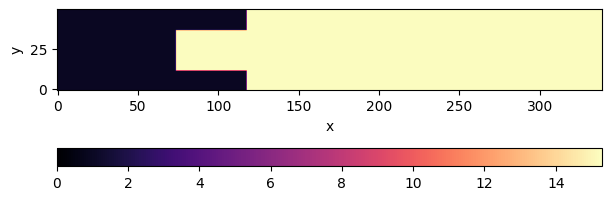

In [8]:
ceviche.viz.abs(epsr, cbar=True)
# ceviche.viz.abs(design_region, cbar=True)

In [8]:
def J(x, y, omega, v, sigma_x, d):
    '''Electric current density'''

    j = -Q_e / (4*pi * d) / np.sqrt(2*pi* sigma_x **2) * np.exp(-(x*dl)**2/(2*sigma_x**2)) * np.exp(-1j * omega/v * (y*dl))
    
    return j

In [9]:
current = np.zeros((Nx, Ny), dtype=np.complex128)
for x in range(Nx):
    for y in range(Ny):
        current[x,y] = J(x - (Npml + xL_PML / dl), y, omega=omega, v=beta*C_0, sigma_x=sigma_x, d=0.5e-9)

<AxesSubplot:xlabel='x', ylabel='y'>

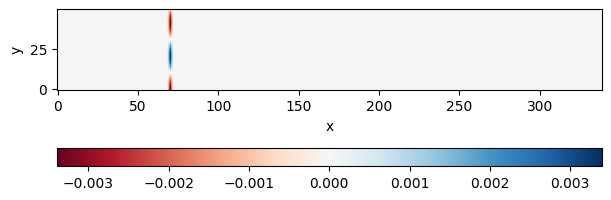

In [10]:
# ceviche.viz.abs(current, cbar=True)
ceviche.viz.real(current, cbar=True)

In [11]:
# Create the simulation object for 'Hz' (TM) polarization
simulation = ceviche.fdfd_hz(omega, dl, epsr, [Npml, 0], bloch_phases=[0, -(omega/(beta*C_0)*a)])

In [12]:
source_tmp = np.zeros((Nx, Ny), dtype=np.complex128)
source_tmp = np.reshape(simulation.Dxb.dot(current.flatten() / (-EPSILON_0 * 1j * omega)), (Nx, Ny))
source_tmp[design_region == 1] = 0

In [13]:
# ceviche.viz.abs(source_tmp, cbar=True)
# ceviche.viz.real(source_tmp, cbar=True)

In [14]:
# Run the simulation with the given source
Ex, Ey, Hz = simulation.solve(source_tmp)
Ey = Ey - current / (EPSILON_0 * 1j * omega)

<AxesSubplot:title={'center':'Hz'}, xlabel='x', ylabel='y'>

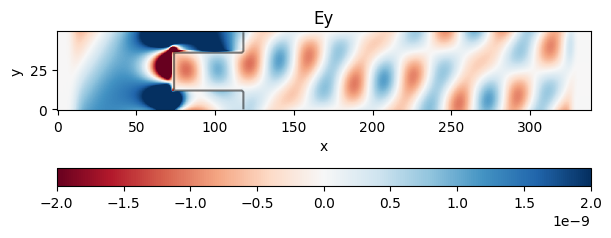

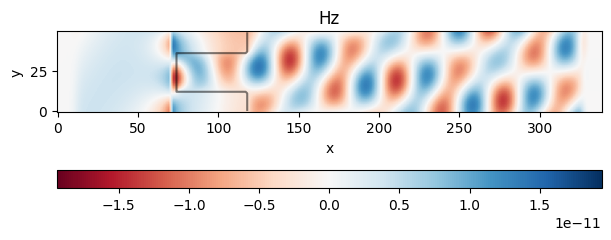

In [15]:
# Visualize the real value of the _ field component
ceviche.viz.real(Ey*np.exp(2*pi*1j*5/12), DK_max=2e-9, DK_title='Ey', outline=epsr, cbar=True)
ceviche.viz.real(Hz, DK_title='Hz', outline=epsr, cbar=True)

### Poynting vector

In [17]:
Sx =  4*2*pi * real( 1/2 * Ey * conj(Hz))
Sy =  4*2*pi * real(-1/2 * Ex * conj(Hz))

<AxesSubplot:title={'center':'Sy'}, xlabel='x', ylabel='y'>

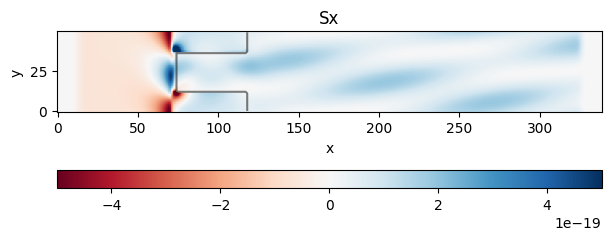

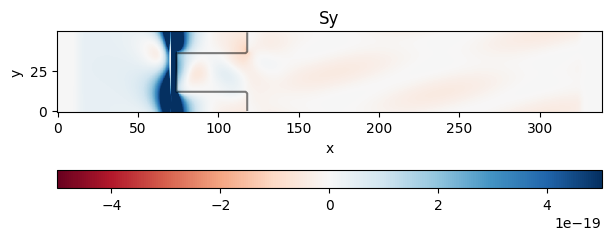

In [18]:
ceviche.viz.real(Sx, DK_max= 5e-19, DK_title='Sx', outline=epsr, cbar=True)
ceviche.viz.real(Sy, DK_max= 5e-19, DK_title='Sy', outline=epsr, cbar=True)

In [19]:
det_x = Nx - Npml - 40
print(f'det_x: \t{det_x}')

np.sum(Sx[det_x, :]) * a

det_x: 	279


7.176189880890613e-25

In [20]:
def concatenate(arr, n, bloch_phase):
    arr2 = arr

    for _ in range(n-1):
        arr2 = arr2 * np.exp(1j*bloch_phase)
        arr = np.concatenate((arr, arr2), axis=1)

    return arr

In [31]:
def energy_flux(Sx):
    """ the energy flux through the detector (per unit detector length) """
    # detector position
    det_x = Sx.shape[0] - 20

    return npa.sum(Sx[det_x, :]*dl) / a


def get_energy_flux(omega, radiation='full'):
    '''The whole simulation in one function'''
    
    bloch_phase = -(omega/(beta*C_0)*a)
    simulation = ceviche.fdfd_hz(omega, dl, epsr, [Npml, 0], bloch_phases=[0, bloch_phase])
    current = np.zeros((Nx, Ny), dtype=np.complex128)
    
    for x in range(Nx):
        for y in range(Ny):
            current[x, y] = J(x - (Npml + pxl(xL_PML)), y, omega=omega, v=beta*C_0, sigma_x=sigma_x, d=0.5e-9)
    
    source_tmp = np.zeros((Nx, Ny), dtype=np.complex128)
    source_tmp = np.reshape(simulation.Dxb.dot(current.flatten() / (-EPSILON_0 * 1j * omega)), (Nx, Ny))
    source_tmp[design_region == 1] = 0
    
    Ex, Ey, Hz = simulation.solve(source_tmp)
    Ey = Ey - current / (EPSILON_0 * 1j * omega)


    XF = Npml + pxl(xL_PML + d + h) + 10
    arr_Hz = Hz[XF:(-Npml), :]
    arr_Ey = Ey[XF:(-Npml), :]
    conc_num = arr_Hz.shape[0] // arr_Hz.shape[1]
    arrC_Hz = concatenate(arr_Hz, conc_num, bloch_phase)
    arrC_Ey = concatenate(arr_Ey, conc_num, bloch_phase)


    if radiation == 'iSPR' or radiation == 'CDR':
        # Fourier Transform
        FFT_Hz = np.fft.fft2(arrC_Hz, s=(arrC_Hz.shape[0], arrC_Hz.shape[1]))
        FFT_Ey = np.fft.fft2(arrC_Ey, s=(arrC_Ey.shape[0], arrC_Ey.shape[1]))

        X = FFT_Hz.shape[1] // 2
        Y = FFT_Hz.shape[0] // 2

    if radiation == 'iSPR':
        FFT_Hz[:, Y:] = 0
        # FFT_Hz[:X, :] = 0
        FFT_Ey[:, Y:] = 0
        # FFT_Ey[:X, :] = 0
        Hz = np.fft.ifft2(FFT_Hz, s=(arrC_Hz.shape[0], arrC_Hz.shape[1]))
        Ey = np.fft.ifft2(FFT_Ey, s=(arrC_Ey.shape[0], arrC_Ey.shape[1]))
    elif radiation == 'CDR':
        FFT_Hz[:, :Y] = 0
        # FFT_Hz[:X, :] = 0
        FFT_Ey[:, :Y] = 0
        # FFT_Ey[:X, :] = 0
        Hz = np.fft.ifft2(FFT_Hz, s=(arrC_Hz.shape[0], arrC_Hz.shape[1]))
        Ey = np.fft.ifft2(FFT_Ey, s=(arrC_Ey.shape[0], arrC_Ey.shape[1]))
    else:
        Hz = arrC_Hz
        Ey = arrC_Ey


    Sx =  4*2*pi * real( 1/2 * Ey * conj(Hz))
    # Sy =  4*2*pi * real(-1/2 * Ex * conj(Hz))

    return energy_flux(Sx)


def get_iSPR_spectrum(start=50e12, end=600e12, steps=100):
    freq_range = np.arange(start, end, (end-start)/steps)
    return list(freq_range), [get_energy_flux(f*2*pi, radiation='iSPR') for f in freq_range]
    

def get_CDR_spectrum(start=50e12, end=600e12, steps=100):
    freq_range = np.arange(start, end, (end-start)/steps)
    return list(freq_range), [get_energy_flux(f*2*pi, radiation='CDR') for f in freq_range]

def get_FULL_spectrum(start=50e12, end=600e12, steps=100):
    freq_range = np.arange(start, end, (end-start)/steps)
    return list(freq_range), [get_energy_flux(f*2*pi, radiation='full') for f in freq_range]

In [35]:
iSPR_spectrum = get_iSPR_spectrum(50e12, 600e12, steps=100)
CDR_spectrum = get_CDR_spectrum(50e12, 600e12, steps=100)
FULL_spectrum = get_FULL_spectrum(50e12, 600e12, steps=100)

In [36]:
iSPR_CDR_spectrum = [x+y for x,y in zip(iSPR_spectrum[1], CDR_spectrum[1])]

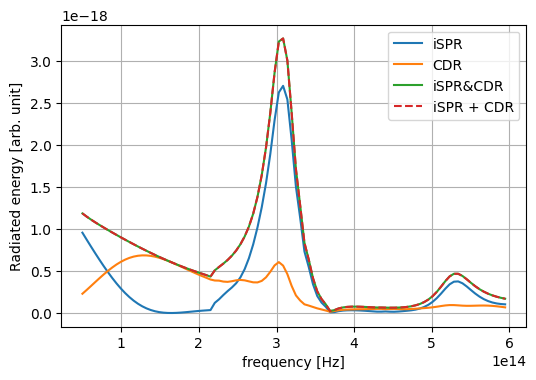

In [37]:
plt.plot(iSPR_spectrum[0], iSPR_spectrum[1], label='iSPR')
plt.plot(CDR_spectrum[0], CDR_spectrum[1], label='CDR')
plt.plot(FULL_spectrum[0], FULL_spectrum[1], label='iSPR&CDR')
plt.plot(iSPR_spectrum[0], iSPR_CDR_spectrum, label='iSPR + CDR', linestyle="--")
plt.xlabel('frequency [Hz]')
plt.ylabel('Radiated energy [arb. unit]')
plt.grid()
plt.legend()
plt.savefig('images/22 Spectra Decomposition/iSPR&CDR_spectra_rect_grating.png')